In [1]:
%matplotlib inline

import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import pandas as pd
import progressbar
import os 

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm

import itertools
from collections import deque

import scipy.stats
import scipy.spatial.distance

import Data, Figures, Models

Data = reload(Data)
Figures = reload(Figures)
Models = reload(Models)

from IPython.display import display, HTML

figureOutputDir = "/home/caleb/Dropbox/CalebBistra/Papers/PNAS_2016/figures/"

In [2]:
shapefile = fiona.open("data/countyBoundaries/countyBoundaries2.shp", "r")
counties = list(shapefile)
shapefile.close()

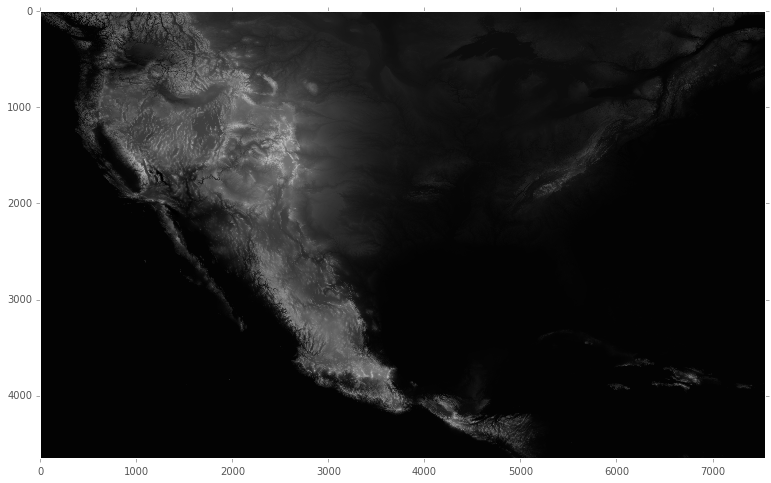

In [3]:
src = rasterio.open("data/usRaster.tif")
noData = src.nodatavals
data = src.read()
src.close()

# rasterio returns a 3-dimensional array of shape (1,width,height), we need to remove the first axis to visualize
data = data.squeeze()


plt.figure(figsize=(16, 8))
plt.imshow(data, interpolation='bilinear', cmap=cm.gray, alpha=1.0)
plt.grid(False)
plt.show()

# Figure 1

Plot the following 3 values where the sea level rise amount varies from 0-10m

- total amount of land affected
- total amount of population affected
- population density of displaced areas


TODO

- Make plots for florida
- Change code to allow for individual levels of sea level rise (don't assume [0,x])

In [4]:
startSeaLevelRise = 0
stopSeaLevelRise = 10
seaLevelRiseRange = range(startSeaLevelRise,stopSeaLevelRise+1)

startYear = 2013
stopYear = 2013
yearRange = range(startYear,stopYear+1)


populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=False)
        
countyIds = Data.loadCounties()
countyIdMap = {countyId:i for i,countyId in enumerate(countyIds)} #mapping from countyId to position in list
countyIndex_IdMap = {i:countyId for i,countyId in enumerate(countyIds)}
countyNameMapping = Data.loadCountyNameMap() #mapping from countyId to name

distanceMatrix = Data.loadCountyPairwiseDistanceMatrix()

Loading the distance matrix


## Calculate Per County Statistics

In [21]:
countyPopulationAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyLandAmountAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyTotalLand = []
percentLandAffected = []

countyNames = dict()
goodCounties = set()

bar = progressbar.ProgressBar()
for x in bar(seaLevelRiseRange):

    tempCountyPopulationAffected = dict()
    tempCountyLandAmountAffected = dict()
    tempCountyTotalLand = dict()
    totalLand = 0.0
    
    for county in counties:
        
        countyId = int(county["properties"]['GEOID'])
        countyName = countyNameMapping[countyId]
        if countyId in countyIds:
            try:
                geoms = [county["geometry"]]

                #src = rasterio.open("usRaster.tif")
                src = rasterio.open("outputs/mask_%d.tif" % (x))
                out_image, out_transform = mask(src, geoms, crop=True, nodata=-999)
                src.close()

                numZero = np.sum(out_image == -999.0)
                numAffected = np.sum(out_image == 1) #we marked raster as 1 if it was reachable by sea level rise
                numNotAffected = np.sum(out_image == 0)

                if x==0:
                    numNotAffected+=numAffected
                    numAffected=0
                
                assert numZero + numAffected + numNotAffected == out_image.count()

                totalNum = numAffected+numNotAffected

                percentAffected = (numAffected) / float(totalNum)
                totalLand += numAffected

                tempCountyPopulationAffected[countyId] = percentAffected
                tempCountyLandAmountAffected[countyId] = numAffected
                tempCountyTotalLand[countyId] = totalNum

                countyNames[countyId] = countyName
                goodCounties.add(countyId)
            except ValueError as e:
                pass
    
    countyPopulationAffected.append(tempCountyPopulationAffected) #TODO: fix this to be dict
    countyLandAmountAffected.append(tempCountyLandAmountAffected)
    countyTotalLand.append(tempCountyTotalLand)

100% (11 of 11) |##########################| Elapsed Time: 0:01:05 Time: 0:01:05


# Process Data for Figures 2 and 3

### Linear fit using IRS data and Population data

In [6]:
fitDegree = 1
numMigrantFunctions = [] #one for each year

for i,year in enumerate(yearRange):
    print "Calculating num migrants by population fit for %d" % (year)
    
    popVals = []
    outgoingMigrations = []
    incomingMigrations = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        outgoingMigrations.append(np.sum(migrationDataSets[i][j,:]))
        incomingMigrations.append(np.sum(migrationDataSets[i][:,j]))
        
    x = np.array(popVals)
    y = np.array(outgoingMigrations)
    x[x<1] = 1
    y[y<1] = 1
    
    coeffs = np.polyfit(x, y, fitDegree)
    print coeffs
    fitFunction = np.poly1d(coeffs)
    
    numMigrantFunctions.append(fitFunction)

print numMigrantFunctions[0](10000)
numMigrantFunctions = [lambda x:3.13670106e-02*x]
print numMigrantFunctions[0](10000)


Calculating num migrants by population fit for 2013
[  8.16740366e-01  -1.03457278e+03]
7132.83087917
313.670106


In [6]:
fitParameters = [] #one for each year

for i,year in enumerate(yearRange):
    print "Calculating num migrants by population fit for %d" % (year)
    
    popVals = []
    exteriorMigrants = []
    interiorMigrants = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        exteriorMigrants.append(np.sum(migrationDataSets[i][j,:])-migrationDataSets[i][j,j])
        interiorMigrants.append(migrationDataSets[i][j,j])
        
    popVals = np.array(popVals)
    exteriorMigrants = np.array(exteriorMigrants)
    interiorMigrants = np.array(interiorMigrants)

    alpha = np.polyfit(popVals, exteriorMigrants, 1)[0]
    beta = np.polyfit(popVals, interiorMigrants, 1)[0]
    
    print alpha,beta
    
    fitParameters.append([alpha,beta])

Calculating num migrants by population fit for 2013
0.0313670997746 0.785373267073


### Run our version of the radiation model

In [7]:
radiationOutputs = []

In [8]:
GENERATE_OUTPUT = False

if GENERATE_OUTPUT:
    for i,year in enumerate(yearRange):
        print "Running radiation model for year %d" % (year)

        tempRadiationOutputs = []
        bar = progressbar.ProgressBar()
        for j,x in bar(list(enumerate(seaLevelRiseRange))):
            SLAi_over_Ai = countyPopulationAffected[j]
            fitFunction = numMigrantFunctions[i]

            SLAi_over_Ai_converted = []


            for k,countyId in enumerate(countyIds):
                if countyId in SLAi_over_Ai:
                    SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
                else:
                    SLAi_over_Ai_converted.append(0)

            T = Models.radiationModel(populationDataSets[i], distanceMatrix, SLAi_over_Ai_converted, fitFunction, countyIds)
            tempRadiationOutputs.append(T)
        radiationOutputs.append(tempRadiationOutputs)
        np.save("radiationModelOutputs_%d" % (year), radiationOutputs)

Running radiation model for year 2013


100% (11 of 11) |################################################################| Elapsed Time: 0:04:15 Time: 0:04:15


In [7]:
Models = reload(Models)

radiationOutputs = []
for i,year in enumerate(yearRange):
    print "Running radiation model for year %d" % (year)
    
    tempRadiationOutputs = []
    alpha,beta = fitParameters[i]
    
    bar = progressbar.ProgressBar()
    for j,x in bar(list(enumerate(seaLevelRiseRange))):
        SLAi_over_Ai = countyPopulationAffected[j]
        
        
        SLAi_over_Ai_converted = []
        
        for k,countyId in enumerate(countyIds):
            if countyId in SLAi_over_Ai:
                SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
            else:
                SLAi_over_Ai_converted.append(0)
       
        T = Models.radiationModelImproved(populationDataSets[i], distanceMatrix, SLAi_over_Ai_converted, alpha, beta, countyIds)
        tempRadiationOutputs.append(T)
    radiationOutputs.append(tempRadiationOutputs)
    #np.save("radiationModelOutputs_%d" % (year), [tempRadiationOutputs])

Running radiation model for year 2013


100% (11 of 11) |##########################| Elapsed Time: 0:03:29 Time: 0:03:29


## Difference from Unaffected Areas

In [8]:
#Full US
lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)


slrOutputRange = range(11)
outputs = []

for seaLevelRiseIndex in slrOutputRange:

    seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
    print "Running comparison for a sea level rise of %d meters" % (seaLevelRiseAmount)
    
    dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
    baselineOutput = radiationOutputs[0][0]

    assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]

    unaffectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v==0:
            unaffectedCountyIds.append(k)
            
    affectedCountyIndices = [countyIdMap[_] for _ in unaffectedCountyIds]        

    #Radiation Data
    interestedData = dependentOutput
    dataRadiation = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }

    #Baseline Data
    interestedData = baselineOutput
    dataBaseline = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }

    dataDifference = {
        countyId: dataRadiation[countyId] - dataBaseline[countyId]
        for i,countyId in enumerate(countyIds)
    }
    
    outputs.append(dataDifference)
    
f = open("difference_unaffected.csv","w")
f.write("FIPS,%s\n" % (','.join(map(lambda x: "%dm" % x,slrOutputRange))))
for i,countyId in enumerate(countyIds):
    f.write("%d" % (countyId))
    for j,meters in enumerate(slrOutputRange):
        f.write(",%d" % (outputs[j][countyId]))
    f.write("\n")
f.close()

Running comparison for a sea level rise of 0 meters
Running comparison for a sea level rise of 1 meters
Running comparison for a sea level rise of 2 meters
Running comparison for a sea level rise of 3 meters
Running comparison for a sea level rise of 4 meters
Running comparison for a sea level rise of 5 meters
Running comparison for a sea level rise of 6 meters
Running comparison for a sea level rise of 7 meters
Running comparison for a sea level rise of 8 meters
Running comparison for a sea level rise of 9 meters
Running comparison for a sea level rise of 10 meters


## Difference All

In [9]:
#Southeast
lats = (24.01, 36.53)
lons = (-99.76, -74.62)

#Full US
lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)

outputs = []

for seaLevelRiseIndex in slrOutputRange:

    seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
    print "Running comparison for a sea level rise of %d meters" % (seaLevelRiseAmount)
    
    dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
    baselineOutput = radiationOutputs[0][0]

    assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]

    affectedCountyIndices = [countyIdMap[_] for _ in goodCounties]        

    #Radiation Data
    interestedData = dependentOutput
    dataRadiation = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }

    #Baseline Data
    interestedData = baselineOutput
    dataBaseline = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }

    
    dataDifference = {
        countyId: dataRadiation[countyId] - dataBaseline[countyId]
        for i,countyId in enumerate(countyIds)
    }
    
    
    outputs.append(dataDifference)

    
f = open("difference_all.csv","w")
f.write("FIPS,%s\n" % (','.join(map(lambda x: "%dm" % x,slrOutputRange))))
for i,countyId in enumerate(countyIds):
    f.write("%d" % (countyId))
    for j,meters in enumerate(slrOutputRange):
        f.write(",%d" % (outputs[j][countyId]))
    f.write("\n")
f.close()

Running comparison for a sea level rise of 0 meters
Running comparison for a sea level rise of 1 meters
Running comparison for a sea level rise of 2 meters
Running comparison for a sea level rise of 3 meters
Running comparison for a sea level rise of 4 meters
Running comparison for a sea level rise of 5 meters
Running comparison for a sea level rise of 6 meters
Running comparison for a sea level rise of 7 meters
Running comparison for a sea level rise of 8 meters
Running comparison for a sea level rise of 9 meters
Running comparison for a sea level rise of 10 meters


## Difference in Incoming Migrants from Affected Areas

In [10]:
#Southeast
lats = (24.01, 36.53)
lons = (-99.76, -74.62)

#Full US
lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)


outputs = []

for seaLevelRiseIndex in slrOutputRange:

    seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
    print "Running comparison for a sea level rise of %d meters" % (seaLevelRiseAmount)
    
    dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
    baselineOutput = radiationOutputs[0][0]

    assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]


    affectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v!=0:
            affectedCountyIds.append(k)
    affectedCountyIndices = [countyIdMap[_] for _ in affectedCountyIds]        

    #Radiation Data
    interestedData = dependentOutput
    dataRadiation = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }

    #Baseline Data
    interestedData = baselineOutput
    dataBaseline = {
        countyId:np.sum(interestedData[affectedCountyIndices,i]) 
        for i,countyId in enumerate(countyIds)
    }
    
    dataDifference = {
        countyId: dataRadiation[countyId] - dataBaseline[countyId]
        for i,countyId in enumerate(countyIds)
    }
    
    outputs.append(dataDifference)
    
    
f = open("difference_affected.csv","w")
f.write("FIPS,%s\n" % (','.join(map(lambda x: "%dm" % x,slrOutputRange))))
for i,countyId in enumerate(countyIds):
    f.write("%d" % (countyId))
    for j,meters in enumerate(slrOutputRange):
        f.write(",%d" % (outputs[j][countyId]))
    f.write("\n")
f.close()

Running comparison for a sea level rise of 0 meters
Running comparison for a sea level rise of 1 meters
Running comparison for a sea level rise of 2 meters
Running comparison for a sea level rise of 3 meters
Running comparison for a sea level rise of 4 meters
Running comparison for a sea level rise of 5 meters
Running comparison for a sea level rise of 6 meters
Running comparison for a sea level rise of 7 meters
Running comparison for a sea level rise of 8 meters
Running comparison for a sea level rise of 9 meters
Running comparison for a sea level rise of 10 meters


## Generate Info Table

In [27]:
countyPopulation = populationDataSets[-1]

slrOutputRange = range(11)
outputs = []

percentCutoff = 0.0005

for seaLevelRiseIndex in slrOutputRange:

    tempTable = {
        "Flooded Counties"     : {"Affected":0, "Unaffected":0, "Both":0, "Neither":0, "Total":0},
        "Non-Flooded Counties" : {"Affected":0, "Unaffected":0, "Both":0, "Neither":0, "Total":0}
    }
    
    seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
    print "Running for a sea level rise of %d meters" % (seaLevelRiseAmount)
    
    dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
    #baselineOutput = migrationDataSets[-1]
    baselineOutput = radiationOutputs[0][0]
    
    assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]

    unaffectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v==0:
            unaffectedCountyIds.append(k)
    unaffectedCountyIndices = [countyIdMap[_] for _ in unaffectedCountyIds]
    
    
    affectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v!=0:
            affectedCountyIds.append(k)
    affectedCountyIndices = [countyIdMap[_] for _ in affectedCountyIds]
    
    
    for affectedCountyIndex in affectedCountyIndices:
        affectedDifference = np.sum(dependentOutput[affectedCountyIndices,affectedCountyIndex]) - np.sum(baselineOutput[affectedCountyIndices,affectedCountyIndex])
        unaffectedDifference = np.sum(dependentOutput[unaffectedCountyIndices,affectedCountyIndex]) - np.sum(baselineOutput[unaffectedCountyIndices,affectedCountyIndex])
        
        countyPop = countyPopulation[affectedCountyIndex]
        affectedPercent = affectedDifference / countyPop
        unaffectedPercent = unaffectedDifference / countyPop
        
        if affectedPercent > percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Flooded Counties"]["Both"] += 1
        elif affectedPercent > percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Flooded Counties"]["Affected"] += 1
        elif affectedPercent <= percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Flooded Counties"]["Unaffected"] += 1  
        elif affectedPercent <= percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Flooded Counties"]["Neither"] += 1

        ''' 
        if affectedDifference > 0 and unaffectedDifference > 0:
            tempTable["Flooded Counties"]["Both"] += 1
        elif affectedDifference > 0 and unaffectedDifference <= 0:
            tempTable["Flooded Counties"]["Affected"] += 1
        elif affectedDifference <= 0 and unaffectedDifference > 0:
            tempTable["Flooded Counties"]["Unaffected"] += 1  
        elif affectedDifference <= 0 and unaffectedDifference <= 0:
            tempTable["Flooded Counties"]["Neither"] += 1
        '''
            
        tempTable["Flooded Counties"]["Total"] += 1
        
        
    for unaffectedCountyIndex in unaffectedCountyIndices:
        
        affectedDifference = np.sum(dependentOutput[affectedCountyIndices,unaffectedCountyIndex]) - np.sum(baselineOutput[affectedCountyIndices,unaffectedCountyIndex])
        unaffectedDifference = np.sum(dependentOutput[unaffectedCountyIndices,unaffectedCountyIndex]) - np.sum(baselineOutput[unaffectedCountyIndices,unaffectedCountyIndex])
        
        countyPop = countyPopulation[unaffectedCountyIndex]
        affectedPercent = affectedDifference / countyPop
        unaffectedPercent = unaffectedDifference / countyPop
        
        if affectedPercent > percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Non-Flooded Counties"]["Both"] += 1
        elif affectedPercent > percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Non-Flooded Counties"]["Affected"] += 1
        elif affectedPercent <= percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Non-Flooded Counties"]["Unaffected"] += 1  
        elif affectedPercent <= percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Non-Flooded Counties"]["Neither"] += 1
        
        '''
        if affectedDifference > 0 and unaffectedDifference > 0:
            tempTable["Non-Flooded Counties"]["Both"] += 1
        elif affectedDifference > 0 and unaffectedDifference <= 0:
            tempTable["Non-Flooded Counties"]["Affected"] += 1
        elif affectedDifference <= 0 and unaffectedDifference > 0:
            tempTable["Non-Flooded Counties"]["Unaffected"] += 1  
        elif affectedDifference <= 0 and unaffectedDifference <= 0:
            tempTable["Non-Flooded Counties"]["Neither"] += 1
        '''
        
        tempTable["Non-Flooded Counties"]["Total"] += 1
    
    
    outputs.append(tempTable)
    
    
    
f = open("paperDataTables.csv","w")

for i,x in enumerate(slrOutputRange):
    
    floodedRow = outputs[i]["Flooded Counties"]
    nonfloodedRow = outputs[i]["Non-Flooded Counties"]
    
    f.write("%d meters,Only SLR Migrants,Only Re-direct Migrants,Both,Neither,Total\n" % (x))
    f.write("Flooded Counties,%d,%d,%d,%d,%d\n" % 
            (floodedRow["Affected"],floodedRow["Unaffected"],floodedRow["Both"],floodedRow["Neither"],floodedRow["Total"]))
    f.write("Non-Flooded Counties,%d,%d,%d,%d,%d\n" % 
            (nonfloodedRow["Affected"],nonfloodedRow["Unaffected"],nonfloodedRow["Both"],nonfloodedRow["Neither"],nonfloodedRow["Total"]))
    f.write("\n")
    
f.close()

Running for a sea level rise of 0 meters
Running for a sea level rise of 1 meters
Running for a sea level rise of 2 meters
Running for a sea level rise of 3 meters
Running for a sea level rise of 4 meters
Running for a sea level rise of 5 meters
Running for a sea level rise of 6 meters
Running for a sea level rise of 7 meters
Running for a sea level rise of 8 meters
Running for a sea level rise of 9 meters
Running for a sea level rise of 10 meters


In [29]:
for i,x in enumerate(slrOutputRange):
    print "%d Meters SLR" % (x)
    df = pd.DataFrame(outputs[i], index=["Affected","Unaffected","Both","Neither","Total"])
    display(df.T)
    print "--------------------------------------------------------------------------------"

0 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties             0           0     0        0      0
Non-Flooded Counties         0           0     0     3108   3108

--------------------------------------------------------------------------------
1 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           132           0     1       97    230
Non-Flooded Counties       918           1    30     1929   2878

--------------------------------------------------------------------------------
2 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           148           0     3      102    253
Non-Flooded Counties      1150           1    38     1666   2855

--------------------------------------------------------------------------------
3 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           155           0     3      102    260
Non-Flooded Counties      1321           1    59     1467   2848

--------------------------------------------------------------------------------
4 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           164           0     7      102    273
Non-Flooded Counties      1679           1    75     1080   2835

--------------------------------------------------------------------------------
5 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           158           0     9      108    275
Non-Flooded Counties      1902           1    87      843   2833

--------------------------------------------------------------------------------
6 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           168           0    10      108    286
Non-Flooded Counties      2077           0    79      666   2822

--------------------------------------------------------------------------------
7 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           169           0    12      107    288
Non-Flooded Counties      2178           0    91      551   2820

--------------------------------------------------------------------------------
8 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           178           0     6      111    295
Non-Flooded Counties      2338           0    68      407   2813

--------------------------------------------------------------------------------
9 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           191           0     8      112    311
Non-Flooded Counties      2421           0    60      316   2797

--------------------------------------------------------------------------------
10 Meters SLR


Affected  Unaffected  Both  Neither  Total
Flooded Counties           194           0     8      115    317
Non-Flooded Counties      2483           0    66      242   2791

--------------------------------------------------------------------------------


## Generate Incoming Migrant Distributions

In [13]:
startYear = 2004
stopYear = 2013
yearRange = range(startYear,stopYear+1)

populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=True)

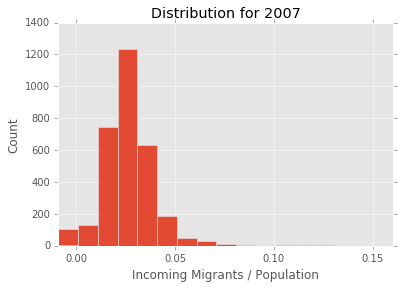

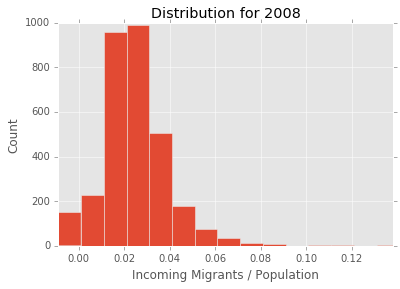

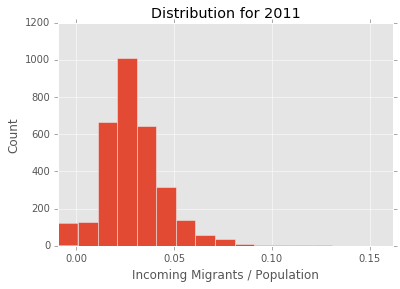

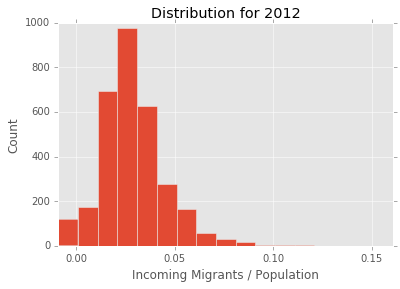

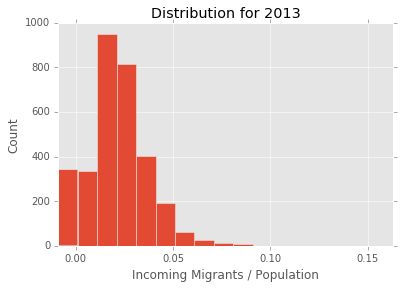

In [14]:
for i,year in enumerate(yearRange):
    
    binwidth = 0.01
    maxVal = 0.2
    
    vals = []
    
    populationData = populationDataSets[i]
    migrationData = migrationDataSets[i]
    
    for j in range(migrationData.shape[0]):
        vals.append(np.sum(migrationData[:,j])/float(populationData[j]))
    
    plt.figure()
    plt.title("Distribution for %d" % (year))
    column = vals
    n, bins, patches = plt.hist(column, bins=np.arange(0-binwidth+0.001, max(column)+binwidth, binwidth))
    #plt.xlim([0,maxVal + binwidth])
    plt.xlim([0-binwidth+0.001,max(column)])
    plt.xlabel("Incoming Migrants / Population")
    plt.ylabel("Count")
    
    plt.show()

    

2004 10338145
2005 10839710
2006 10259952
2007 10364373
2008 10005844
2009 9657816
2010 9783847
2011 11525608
2012 11867402
2013 10009097


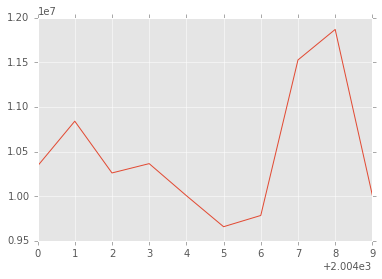

In [15]:
y=[]
x=[]
for i,year in enumerate(yearRange):

    
    populationData = populationDataSets[i]
    migrationData = migrationDataSets[i]
    
    print year, np.sum(migrationData)
    x.append(year)
    y.append(np.sum(migrationData))
    
plt.figure()
plt.plot(x,y)
plt.show()

Running for a sea level rise of 0 meters
43332.9700108


ValueError: max() arg is an empty sequence

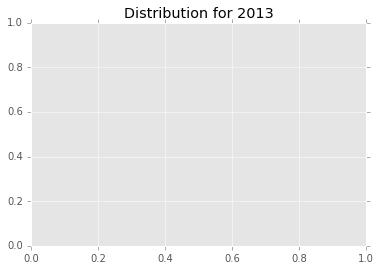

In [16]:
countyPopulation = populationDataSets[-1]

slrOutputRange = range(11)
outputs = []

percentCutoff = 0.02

for seaLevelRiseIndex in slrOutputRange:

    y = []
    
    tempTable = {
        "Flooded Counties"     : {"Affected":0, "Unaffected":0, "Both":0, "Neither":0, "Total":0},
        "Non-Flooded Counties" : {"Affected":0, "Unaffected":0, "Both":0, "Neither":0, "Total":0}
    }
    
    seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
    print "Running for a sea level rise of %d meters" % (seaLevelRiseAmount)
    
    print radiationOutputs[0][seaLevelRiseIndex][0,0]
    
    dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
    baselineOutput = migrationDataSets[-1]
    #baselineOutput = radiationOutputs[0][0]
    
    assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]

    unaffectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v==0:
            unaffectedCountyIds.append(k)
    unaffectedCountyIndices = [countyIdMap[_] for _ in unaffectedCountyIds]
    
    
    affectedCountyIds = []
    for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
        if v!=0:
            affectedCountyIds.append(k)
    affectedCountyIndices = [countyIdMap[_] for _ in affectedCountyIds]
    
    
    for affectedCountyIndex in affectedCountyIndices:
        affectedDifference = np.sum(dependentOutput[affectedCountyIndices,affectedCountyIndex]) - np.sum(baselineOutput[affectedCountyIndices,affectedCountyIndex])
        unaffectedDifference = np.sum(dependentOutput[unaffectedCountyIndices,affectedCountyIndex]) - np.sum(baselineOutput[unaffectedCountyIndices,affectedCountyIndex])
        
        
        
        countyPop = countyPopulation[affectedCountyIndex]
        affectedPercent = affectedDifference / countyPop
        unaffectedPercent = unaffectedDifference / countyPop
        
        y.append(affectedPercent)
        
        if affectedPercent > percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Flooded Counties"]["Both"] += 1
        elif affectedPercent > percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Flooded Counties"]["Affected"] += 1
        elif affectedPercent <= percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Flooded Counties"]["Unaffected"] += 1  
        elif affectedPercent <= percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Flooded Counties"]["Neither"] += 1

        ''' 
        if affectedDifference > 0 and unaffectedDifference > 0:
            tempTable["Flooded Counties"]["Both"] += 1
        elif affectedDifference > 0 and unaffectedDifference <= 0:
            tempTable["Flooded Counties"]["Affected"] += 1
        elif affectedDifference <= 0 and unaffectedDifference > 0:
            tempTable["Flooded Counties"]["Unaffected"] += 1  
        elif affectedDifference <= 0 and unaffectedDifference <= 0:
            tempTable["Flooded Counties"]["Neither"] += 1
        '''
            
        tempTable["Flooded Counties"]["Total"] += 1
    
    plt.figure()
    plt.title("Distribution for %d" % (year))
    column = y
    n, bins, patches = plt.hist(column, bins=np.arange(0-binwidth+0.001, max(column)+binwidth, binwidth))
    #plt.xlim([0,maxVal + binwidth])
    plt.xlim([0-binwidth+0.001,max(column)])
    plt.xlabel("Incoming Migrants / Population")
    plt.ylabel("Count")
    
    plt.show()
    
    y=[]
        
    for unaffectedCountyIndex in unaffectedCountyIndices:
        
        affectedDifference = np.sum(dependentOutput[affectedCountyIndices,unaffectedCountyIndex]) - np.sum(baselineOutput[affectedCountyIndices,unaffectedCountyIndex])
        unaffectedDifference = np.sum(dependentOutput[unaffectedCountyIndices,unaffectedCountyIndex]) - np.sum(baselineOutput[unaffectedCountyIndices,unaffectedCountyIndex])
        
        countyPop = countyPopulation[unaffectedCountyIndex]
        affectedPercent = affectedDifference / countyPop
        unaffectedPercent = unaffectedDifference / countyPop
        
        y.append(affectedPercent)
        
        if affectedPercent > percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Non-Flooded Counties"]["Both"] += 1
        elif affectedPercent > percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Non-Flooded Counties"]["Affected"] += 1
        elif affectedPercent <= percentCutoff and unaffectedPercent > percentCutoff:
            tempTable["Non-Flooded Counties"]["Unaffected"] += 1  
        elif affectedPercent <= percentCutoff and unaffectedPercent <= percentCutoff:
            tempTable["Non-Flooded Counties"]["Neither"] += 1
        
        '''
        if affectedDifference > 0 and unaffectedDifference > 0:
            tempTable["Non-Flooded Counties"]["Both"] += 1
        elif affectedDifference > 0 and unaffectedDifference <= 0:
            tempTable["Non-Flooded Counties"]["Affected"] += 1
        elif affectedDifference <= 0 and unaffectedDifference > 0:
            tempTable["Non-Flooded Counties"]["Unaffected"] += 1  
        elif affectedDifference <= 0 and unaffectedDifference <= 0:
            tempTable["Non-Flooded Counties"]["Neither"] += 1
        '''
        
        tempTable["Non-Flooded Counties"]["Total"] += 1
    
        
    plt.figure()
    plt.title("Distribution for %d" % (year))
    column = y
    n, bins, patches = plt.hist(column, bins=np.arange(0-binwidth+0.001, max(column)+binwidth, binwidth))
    #plt.xlim([0,maxVal + binwidth])
    plt.xlim([0-binwidth+0.001,max(column)])
    plt.xlabel("Incoming Migrants / Population")
    plt.ylabel("Count")
    
    plt.show()

In [ ]:
startYear = 2013
stopYear = 2013
yearRange = range(startYear,stopYear+1)

populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=False)

In [ ]:
y = []
y1 = []
for i in range(migrationDataSets[0].shape[0]):
    
    
    rowSum = float(sum(migrationDataSets[0][i,:]))
    #y1.append(float(rowSum-migrationDataSets[0][i,i])/float(populationDataSets[0][i]))
    #y1.append(float(migrationDataSets[0][i,i])/float(populationDataSets[0][i]))
    selfMigrants = float(migrationDataSets[0][i,i])
    if selfMigrants!=0:
        y1.append( (rowSum-selfMigrants) / selfMigrants)
    
    
plt.figure()
plt.title("Distribution for %d" % (year))
column = y1
n, bins, patches = plt.hist(column, bins=np.arange(0-binwidth+0.001, max(column)+binwidth, binwidth))
#plt.xlim([0,maxVal + binwidth])
plt.xlim([0-binwidth+0.001,max(column)])
plt.xlabel("Incoming Migrants / Population")
plt.ylabel("Count")

plt.show()

In [ ]:
x = []
y = []
for i in range(migrationDataSets[0].shape[0]):
    
    x.append(float(populationDataSets[0][i]))
    y.append(float(migrationDataSets[0][i,i]))
    
    
plt.figure()
plt.title("Distribution for %d" % (year))
plt.scatter(x,y)
plt.xlabel("Incoming Migrants / Population")
plt.ylabel("Count")

plt.show()